# Build a Word Embedding Engine and MVP Chatbot

In [3]:
!mkdir results

Training aviation English word embeddings...
Epoch 0, Loss: 16.2161
Epoch 20, Loss: 0.7958
Epoch 40, Loss: 0.1823
Epoch 60, Loss: 0.0963
Epoch 80, Loss: 0.0687
Epoch 100, Loss: 0.0554
Epoch 120, Loss: 0.0473
Epoch 140, Loss: 0.0417
Epoch 160, Loss: 0.0376
Epoch 180, Loss: 0.0345

Aviation English Word Relationships:


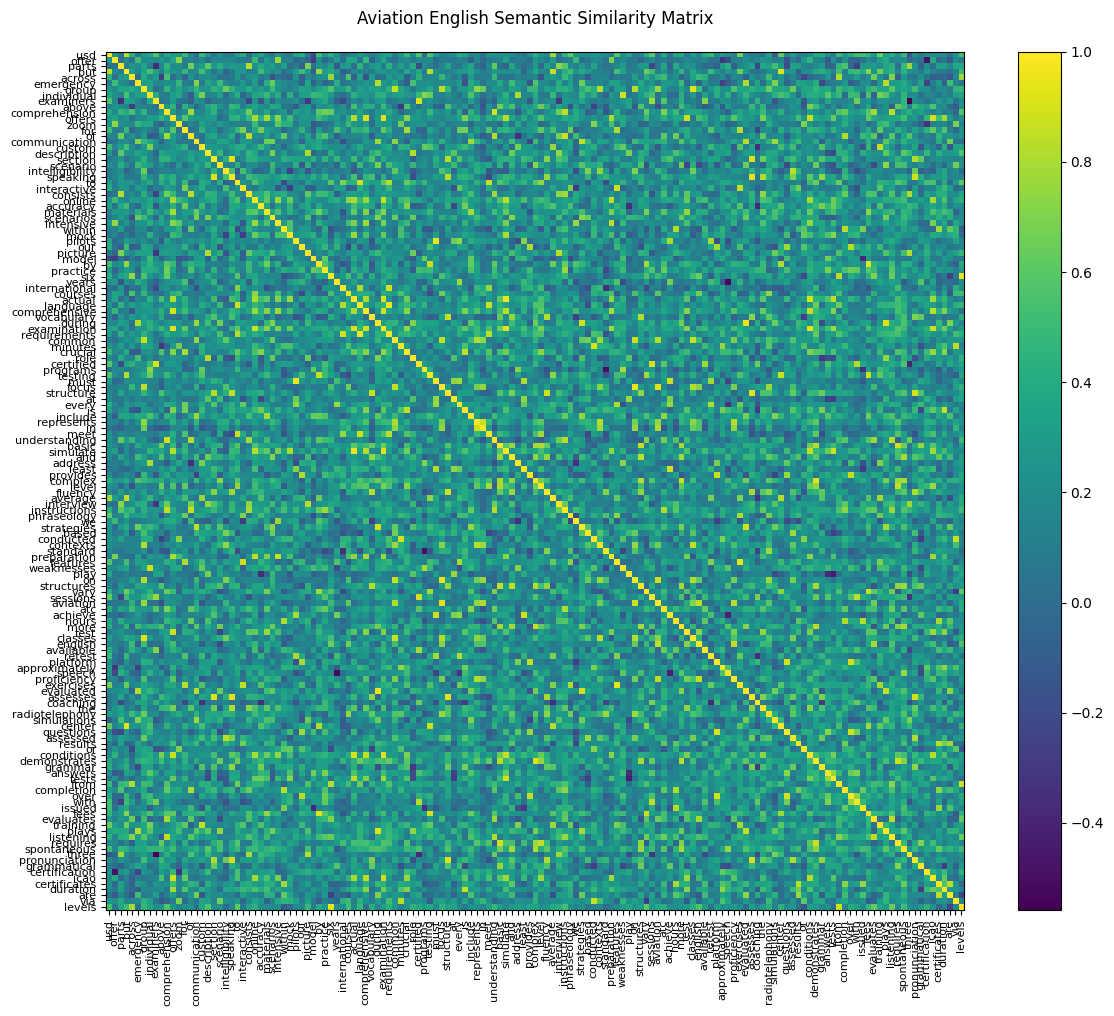

In [17]:
import nltk
from nltk.tokenize import word_tokenize
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

# Enhanced ICAO-specific corpus with aviation terminology
icao_corpus = [
    # Test information
    "The ICAO English Proficiency Test evaluates aviation English across six levels from 1 to 6.",
    "Pilots must achieve at least ICAO Level 4 to meet international language requirements.",
    "The test consists of three parts: interview, picture description, and role play scenarios.",
    "ICAO test duration is approximately 30-45 minutes conducted via Zoom or in-person.",
    "Test results and certificates are issued within 24 hours of completion.",

    # Preparation resources
    "Level6Aviation.com offers comprehensive ICAO test preparation materials.",
    "Our platform provides over 2,000 practice questions with model answers.",
    "ICAO4Pilots.com features interactive exercises for phraseology training.",
    "Aviation English courses focus on radiotelephony and standard phraseology.",
    "Practice materials include ATC communication simulations and emergency scenarios.",

    # Test components
    "The speaking section assesses pronunciation, structure, vocabulary and fluency.",
    "Listening comprehension evaluates understanding of ATC instructions.",
    "Grammar accuracy is crucial for ICAO Level 4 and above.",
    "Pronunciation is assessed based on intelligibility in aviation contexts.",
    "Communication strategies are evaluated during emergency scenario role plays.",

    # Requirements
    "ICAO Level 4 requires basic grammatical structures and vocabulary.",
    "Level 5 demonstrates more complex structures and spontaneous speech.",
    "Level 6 represents native-like proficiency in aviation English.",
    "Pilots must retest every 3 years for ICAO English certification.",
    "Test fees vary by testing center but average $200-300 USD.",

    # Training options
    "We offer intensive 2-week ICAO preparation courses online.",
    "One-on-one coaching sessions with certified examiners available.",
    "Group classes focus on common aviation communication scenarios.",
    "Custom training programs address individual weaknesses.",
    "Mock tests simulate actual ICAO examination conditions."
]

class EnhancedWordEmbeddingModel:
    def __init__(self, corpus, embedding_dim=16, window_size=3):
        nltk.download('punkt', quiet=True)
        self.corpus = corpus
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self._build_vocabulary()
        self.embedding = nn.Embedding(len(self.vocab), embedding_dim)

    def _build_vocabulary(self):
        self.tokens = set(word for sentence in self.corpus
                         for word in word_tokenize(sentence.lower())
                         if word.isalpha())  # Only keep alphabetic words
        self.vocab = {word: i for i, word in enumerate(self.tokens)}
        self.idx2word = {i: word for word, i in self.vocab.items()}

    def build_co_occurrence_matrix(self):
        self.co_matrix = torch.zeros((len(self.vocab), len(self.vocab)))
        for sentence in self.corpus:
            words = [w for w in word_tokenize(sentence.lower()) if w in self.vocab]
            for i, center_word in enumerate(words):
                start = max(0, i - self.window_size)
                end = min(len(words), i + self.window_size + 1)
                for j in range(start, end):
                    if i != j:
                        self.co_matrix[self.vocab[center_word], self.vocab[words[j]]] += 1
        # Add smoothing
        self.co_matrix += 0.1

    def train(self, epochs=200, learning_rate=0.05):
        optimizer = optim.Adam(self.embedding.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()
        word_indices = torch.arange(len(self.vocab))

        for epoch in range(epochs):
            optimizer.zero_grad()
            embeddings = self.embedding(word_indices)
            sim_scores = torch.mm(embeddings, embeddings.t())
            loss = loss_fn(sim_scores, self.co_matrix)
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    def get_sentence_embedding(self, sentence):
        tokens = [word for word in word_tokenize(sentence.lower())
                 if word in self.vocab and word.isalpha()]
        if not tokens:
            return None
        indices = torch.tensor([self.vocab[word] for word in tokens])
        with torch.no_grad():
            word_embeddings = self.embedding(indices)
            return word_embeddings.mean(dim=0).numpy()

    def visualize_similarities(self, top_n=15):
        with torch.no_grad():
            embeddings = self.embedding(torch.arange(len(self.vocab)))
            similarities = cosine_similarity(embeddings.numpy())

            plt.figure(figsize=(12, 10))
            plt.imshow(similarities, cmap='viridis')
            plt.xticks(range(len(self.vocab)), [self.idx2word[i] for i in range(len(self.vocab))],
                       rotation=90, fontsize=8)
            plt.yticks(range(len(self.vocab)), [self.idx2word[i] for i in range(len(self.vocab))],
                       fontsize=8)
            plt.title("Aviation English Semantic Similarity Matrix", pad=20)
            plt.colorbar()
            plt.tight_layout()
            plt.show()

# Enhanced intent bank with multiple variations
intent_bank = {
    "test_format": [
        "What does the ICAO test consist of?",
        "How is the ICAO exam structured?",
        "What are the components of the aviation English test?",
        "Tell me about the test format"
    ],
    "preparation": [
        "How can I prepare for the ICAO test?",
        "What resources are available for study?",
        "Where can I find practice materials?",
        "Recommend preparation methods"
    ],
    "requirements": [
        "What level do I need to pass?",
        "What are the ICAO language requirements?",
        "How good does my English need to be?",
        "What's the minimum passing grade?"
    ],
    "retesting": [
        "How often do I need to retest?",
        "Is the certification permanent?",
        "When does my certificate expire?",
        "Retesting frequency"
    ],
    "scoring": [
        "How is the test scored?",
        "What criteria are used for evaluation?",
        "How do they assess pronunciation?",
        "What makes a Level 6 candidate?"
    ],
    "training": [
        "Do you offer preparation courses?",
        "Where can I get training?",
        "Recommend good aviation English schools",
        "Looking for ICAO test coaching"
    ]
}

class AviationChatbot:
    def __init__(self, model, intent_bank):
        self.model = model
        self.intent_bank = intent_bank
        self.responses = {
            "test_format": "The ICAO test has three parts:\n1. Interview about aviation experience\n"
                         "2. Picture description of aviation scenarios\n3. Role-play of ATC communications\n"
                         "Duration: 30-45 minutes\nFormat: Zoom or in-person",

            "preparation": "Recommended preparation:\n1. ICAO4Pilots.com for phraseology\n"
                          "2. Level6Aviation.com mock tests\n3. Our 2,000+ question database\n"
                          "4. Practice with ATC communication simulations",

            "requirements": "ICAO Level Requirements:\n\nLevel 4 (Minimum):\n- Basic grammar with some errors\n"
                          "- Routine operation vocabulary\n- Mostly intelligible pronunciation\n\n"
                          "Level 6 (Expert):\n- Native-like proficiency\n- Handles complex situations",

            "retesting": "Certificate Validity:\n\n- Level 4: 3 years\n- Level 5: 6 years\n"
                        "- Level 6: Lifetime\n\nMost airlines require renewal every 3 years regardless of level.",

            "scoring": "Scoring Criteria (1-6 in each):\n1. Pronunciation\n2. Structure (grammar)\n"
                      "3. Vocabulary\n4. Fluency\n5. Comprehension\n6. Interactions\n\n"
                      "Your overall level is the lowest of these six scores.",

            "training": "Training Options:\n\n1. Intensive 2-week course ($399)\n"
                       "2. Private coaching ($75/hour)\n3. Group classes ($199/month)\n"
                       "4. Mock tests with feedback ($150)\n\nAll include aviation scenario practice"
        }

    def get_response(self, user_input):
        # Calculate similarity to all intent examples
        scores = {}
        for intent, examples in self.intent_bank.items():
            max_sim = max([
                cosine_similarity(
                    [self.model.get_sentence_embedding(user_input)],
                    [self.model.get_sentence_embedding(ex)]
                )[0][0] for ex in examples if self.model.get_sentence_embedding(ex) is not None
            ], default=0)
            scores[intent] = max_sim

        best_intent = max(scores, key=scores.get)

        if scores[best_intent] < 0.4:  # Similarity threshold
            fallbacks = [
                "Could you rephrase your question about ICAO English?",
                "I'm not sure I understand. Are you asking about test format, preparation, or requirements?",
                "My expertise is ICAO aviation English. Could you ask about test preparation or requirements?"
            ]
            return random.choice(fallbacks)

        return self.responses[best_intent]

# Initialize and train model
print("Training aviation English word embeddings...")
model = EnhancedWordEmbeddingModel(icao_corpus, embedding_dim=16)
model.build_co_occurrence_matrix()
model.train(epochs=200)

# Show similarity matrix
print("\nAviation English Word Relationships:")
model.visualize_similarities()

In [19]:
# Initialize chatbot
chatbot = AviationChatbot(model, intent_bank)

# Chat interface
print("\n✈️ ICAO Aviation English Assistant (Type 'quit' to exit)\n")
while True:
    try:
        user_input = input("You: ").strip()
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Safe flights! Goodbye.")
            break

        if not user_input:
            continue

        response = chatbot.get_response(user_input)
        print("Bot:", response, "\n")

    except (KeyboardInterrupt, EOFError):
        print("\nSession ended.")
        break


✈️ ICAO Aviation English Assistant (Type 'quit' to exit)

You: How is the test scored?
Bot: Scoring Criteria (1-6 in each):
1. Pronunciation
2. Structure (grammar)
3. Vocabulary
4. Fluency
5. Comprehension
6. Interactions

Your overall level is the lowest of these six scores. 


Session ended.
